# Exercise 3 - R:  Multi-class Classification and Neural Networks

## *Part One*: Multi-class Classification with Logistic Regression

Recognizing handwritten digits.  Though the source is not explicitly mentioned, it is just like the [MNIST database](https://en.wikipedia.org/wiki/MNIST_database).

Each value of $X$ will be a 20x20 grid of values representing the grayscale intensity at that location "unrolled" into a 400-dimensional vector.  Here is an example for the first number in our data, $X^{(1)}$:

$\hspace{1cm} X^{(1)} = \begin{bmatrix}x_{(1, 1)}^{(1)},\ x_{(1, 2)}^{(1)},\ \dots\ x_{(1, 20)}^{(1)} \\
                                    x_{(2, 1)}^{(1)},\ x_{(2, 2)}^{(1)},\ \dots\ x_{(2, 20)}^{(1)} \\
                                    \vdots \\ 
                                    x_{(20, 1)}^{(1)},\ x_{(20, 2)}^{(1)},\ \dots\ x_{(20, 20)}^{(1)} \\ 
                    \end{bmatrix}
\rightarrow \begin{bmatrix} x_1^{(1)},\ x_2^{(1)},\ \dots\ x_{400}^{(1)} \end{bmatrix}
\rightarrow (x^{(1)})^T$

Here is our collection of all of the numbers for $X$:

$\hspace{1cm} X = \begin{bmatrix} (x^{(1)})^T \\ (x^{(2)})^T \\ \vdots \\ (x^{(400)})^T \end{bmatrix}$

---

Beginning with package imports, data loading, and initial visualization

In [1]:
rm(list=ls())  # Clearing all environment variables

suppressPackageStartupMessages({
  library(R.matlab)  # Reads MATLAB/Octave  matrices
  library(utils)  # Used for a status bar in lengthy for loops
  library(nnet)  # For comparing answers
  library(ggplot2)
  library(tidyr)
  library(dplyr)
})

theme_update(plot.title = element_text(hjust = 0.5))  # Centers ggplot2 titles

Warning message:
"package 'R.matlab' was built under R version 3.3.3"Warning message:
"package 'tidyr' was built under R version 3.3.3"

In [2]:
# Loading in the data from the .mat files
data <- readMat('ex3/ex3data1.mat')

# Assigning X/y and removing data from environment
X <- data$X
y <- data$y
rm(data)  # Clearing data from environment

# Replacing where 0 is marked as 10 in y
y <- ifelse(y == 10, 0, y)

# Adding the intercept term for X
X <- cbind(1, X)

# An array of 0s for starting values of theta to be used to test functions
initialTheta <- numeric(dim(X)[2])

print(dim(X))

[1] 5000  401


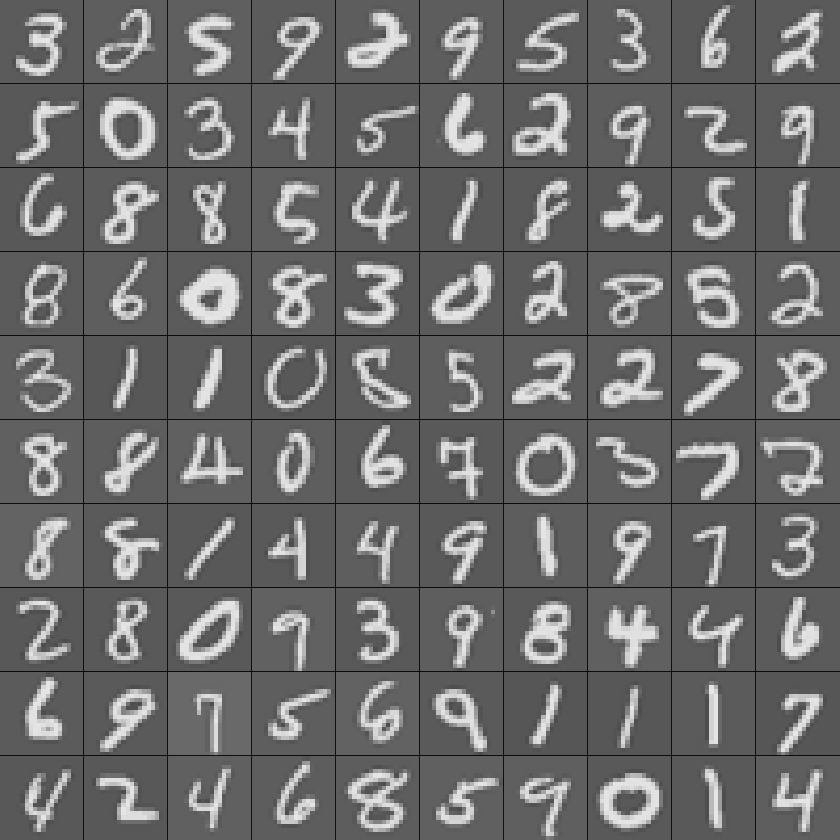

In [3]:
# Randomly selecting 100 digits to plot
rowsToPlot <- X[sample(nrow(X),size=100,replace=FALSE),]

row_to_matrix <- function(row) {
  # Formats a row from the matrix X into a matrix suitable for plotting with image()
  digit <- matrix(row, nrow=20, ncol=20)  # Puts row into a 20x20 matrix
  digit <- t(apply(digit, 2, rev))  # Rotates matrix into correct position for image()
  return(digit)
}

plot_digits <- function(digits) {
  # Plots a grid of the supplied digits
  
  # Calculating parameters for the plot
  m <- dim(digits)[1]  # Number of digits to plot
  columns <- floor(sqrt(m))  # Number of columns
  rows <- ceiling(sqrt(m))  # Number of rows

  # Parameters for the overall plot
  par(mfrow=c(rows, columns),  # Rows, columns
      mar=c(0.0, 0.0, 0.0, 0.0))  # Margins between plots

  # Looping through the digits and plotting them
  for (i in 1:m) {
  image(row_to_matrix(digits[i, -1]),  # Formats digit and removes intercept term
        col=grey.colors(255),  # Colors to gray scale
        xaxt='n', yaxt='n')  # Remoxes axis labels and tick marks
  }
}

plot_digits(rowsToPlot)

### Vectorizing Logistic Regression

We'll be taking a matrix multiplication approach to vectorize both the cost function and the gradient for logistic regression.  My previous notebooks for assignment \#2 ([Python](http://nbviewer.jupyter.org/github/JeffMacaluso/Misc/blob/master/MachineLearningMOOC/Ex2%20Python%20-%20Logistic%20Regression.ipynb) | [R](http://nbviewer.jupyter.org/github/JeffMacaluso/Misc/blob/master/MachineLearningMOOC/Ex2%20R%20-%20Logistic%20Regression.ipynb) | [Julia](http://nbviewer.jupyter.org/github/JeffMacaluso/Misc/blob/master/MachineLearningMOOC/Ex2%20Julia%20-%20Logistic%20Regression.ipynb)) already use a vectorized approach, but I'll have a little more information describing what is happening below.

- **Note:** The assignment calls for creating the functions for unregularized logistic regression and later modifying them for regularization, but I'm just going to write the functions for regularized logistic regression right away since the regularization parameter is generally just an addition at the end of the equations.

To illustrate this vectorization process, here is how we vectorize our hypothesis, $h_\theta(x)$, using matrix multiplication with the axiom that $a^Tb = b^Ta$ if $a$ and $b$ are vectors:

Defining $X$ and $\theta$ as

$\hspace{1cm} X = \begin{bmatrix} (x^{(1)})^T \\ (x^{(2)})^T \\ \vdots \\ (x^{(m)})^T \end{bmatrix} \hspace{0.5cm}$ and $\hspace{0.5cm} \theta = \begin{bmatrix} \theta_0 \\ \theta_1 \\ \vdots \\ \theta_n \end{bmatrix}$

Computing matrix product $X\theta$:

$\hspace{1cm} X\theta = \begin{bmatrix} (x^{(1)})^T\theta \\ (x^{(2)})^T\theta \\ \vdots \\ (x^{(m)})^T\theta \end{bmatrix} \hspace{0.5cm} = \hspace{0.5cm} \begin{bmatrix} \theta^T(x^{(1)}) \\ \theta^T(x^{(2)}) \\ \vdots \\ \theta^T(x^{(m)}) \end{bmatrix}$

Basically, the main difference between the vectorized approach and non-vectorized approach is through linear algebra.  The non-vectorized approach would be element-wise (individually compute the cost function/gradient/etc. for each element individually), whereas the vectorized is through matrices.

#### Vectorized Cost Function

$J(\theta) = \frac{1}{m} \sum_{i=1}^m[-y^{(i)}log(h_\theta(x^{(i)})) - (1-y^{(i)})log(1-h_\theta(x^{(i)}))] + \frac{\lambda}{2m} \sum_{j=1}^n \theta_j^2$

In [4]:
# One hot encoding 7 for testing functions 
y7 <- ifelse(y == 7, 1, 0)


logistic_hypothesis <- function(theta, X) {
  # Calculates the hypothesis for X given values of
  # theta for logistic regression
  X <- as.matrix(X)
  theta <- as.matrix(theta)
  
  h <- X %*% theta  # Linear prediction
  h <- 1/(1+exp(-h))  # Sigmoid function
  return(h)
}

regularized_cost <- function(theta, X, y, C=0.0) {
  # Computes cost for logistic regression
  m <- length(y)
  h <- logistic_hypothesis(theta, X)
  error <- sum(-y*log(h)-(1-y)*log(1-h))
  
  # Calculating the regularization parameter
  # Avoiding the regularization parameter for the first theta
  regularizedTheta <- theta[-1] ** 2
  regularization <- (C/(2*m)) * sum(regularizedTheta)
  
  J <- (1/m)*error + regularization
  return(J)
}

regularized_cost(initialTheta, X, y7)

[1] 0.6931472

#### Vectorized Gradient

$\frac{\partial J(\theta)}{\partial \theta_j} = \begin{cases} 
\hspace{0.25cm} \frac{1}{m} \sum_{i=1}^m (h_\theta(x^{(i)}) - y^{(i)})x_j^{(i)} & \text{for}\ j = 0 \\
\Big(\frac{1}{m} \sum_{i=1}^m (h_\theta(x^{(i)}) - y^{(i)})x_j^{(i)}\Big) + \frac{\lambda}{m}\theta_j & \text{for}\ j \geq 1
\end{cases}$

In [5]:
regularized_gradient <- function(theta, X, y, C=0.0) {
  # Computes the gradient for logistic regression
  X <- as.matrix(X)
  y <- as.matrix(y)
  theta <- as.matrix(theta)
  m <- length(y)
  h <- logistic_hypothesis(theta, X)
    
  # Calculating the regularization parameter for all thetas but the intercept
  regParam <- (C/m) * theta[-1]
    
  gradient <- (1/m) * (t(X) %*% (h-y))
  gradient[-1] <- gradient[-1] + regParam
  return(gradient)
}

regularized_gradient(initialTheta, X, y7)[1:5]

[1]  4.000000e-01  0.000000e+00  0.000000e+00  7.745302e-08 -5.300466e-07

Finding optimal values for $\theta$

Using the CG method per the exercise instructions as it is more efficient at dealing with a large number of parameters.

In [6]:
optimize_theta <- function(X, y, C=0.0) {
  # Find values of theta that minimize the cost function
  # Takes roughly four minutes per digit
  optimalTheta <- optim(
        # Specifying function parameters
        par=initialTheta,  # Initial guess
        fn=regularized_cost,  # Function to minimize
        X=X,
        y=y,
        C=C,
        method="CG",  #  Optimization function to use
        control=list(maxit = 40)  # Maximum number of iterations
      )$par  # Specifying that we only want the obtained thetas
  return(optimalTheta)
}

# Beginning timing
startTime <- proc.time()  

optimize_theta(X, y7)[1:5]

endTime <- proc.time()  
endTime - startTime

[1] -6.755808e-01  0.000000e+00  0.000000e+00 -3.608285e-06  2.661423e-05

   user  system elapsed 
 263.11    1.04  295.05 

#### One-vs-all Classification

In order to predict the digit for each $X^{(i)}$, we need to create a function to do one-vs-all classification.  This means training 10 models (one for each unique value of $y$) to estimate the class likelihood of each digit, and then assign each value of $X^{(i)}$ a digit.  

This function first finds the **optimal $\theta$ values** for each model and places them into a table:

|      | 0    | 1    | ...  | 9    |
|------|------|------|------|------|
|   0  |-8.014|-3.071| ...  |-5.507|
|   1  | 0.000| 0.000| ...  | 0.000|
| ...  | ...  | ...  | ...  | ...  |
| 401  | 0.000| 0.000| ...  | 0.000|


And then calculates the **class probabilities** for each value of $X^{(i)}$ and places them into a table:

|      | 0    | 1    | ...  | 9    |
|------|------|------|------|------|
|   0  | 0.999| 0.001| ...  | 0.001|
|   1  | 0.999| 0.001| ...  | 0.001|
| ...  | ...  | ...  | ...  | ...  |
| 5000 | 0.001| 0.001| ...  | 0.999|


From here, we just grab the column that has the highest value

In [7]:
one_vs_all <- function(X, y, C=0.) {
  # Predictions the digit for each value of X
  # Calculates the optimal values for theta and one hot encodes values for y

  # One hot encoding y
  yOneHot <- y %>% 
    data.frame(digit=.) %>%  # Creating a data frame
    mutate(id = 1:n(), dummy = 1) %>%  # Adding columns before the encoding
    spread(digit, value = dummy, fill = 0) %>%  # One hot encoding
    select(-id)  # Removing ID
  
  # Converting the one hot encoding into a matrix to make it easier to use
  # as an argument when optimizing thetas
  yOneHotMat <- as.matrix(yOneHot)
  
  
  # Creating a data frame to fill with optimal thetas for each digit
  optimalThetas <- data.frame(initialTheta)
  # optimalThetas <- data.frame()
  
  # Filling the data frame with optimal thetas for each digit
  print('Beginning Optimizing Thetas')
  pb <- txtProgressBar(min=0, max=length(unique(y)), style=3)  # Status bar
  for (i in 1:length(unique(y))) {
    digit <- yOneHotMat[, i]  # Selects one hot column for y argument
    optimalTheta <- optimize_theta(X, digit, C)  # Optimizing thetas
    optimalThetas[, i] <- optimalTheta  # Appends thetas
    setTxtProgressBar(pb, i)  # Updates status bar
  }
  # close(pb) 
  print('Optimizing Thetas Completed')
  
  colnames(optimalThetas) <- 0:(length(colnames(optimalThetas))-1)  # Renaming columns to digits
  
  
  # Creating a data frame to fill with class probabilities for each digit
  classProbabilities <- data.frame(id=1:dim(X)[1])
  
  # Filling the data frame with the class probability of each digit
  for (i in 1:length(unique(y))) {
    classProb <- logistic_hypothesis(optimalThetas[i], X)
    classProbabilities[, i] <- classProb
  }
  colnames(classProbabilities) <- 0:(length(colnames(classProbabilities))-1)  # Renaming columns to digits
  
  # Returns the column number with the highest value
  prediction <- colnames(classProbabilities)[max.col(classProbabilities,ties.method="first")]
  
  print('Predictions Completed')
  return(prediction)
}

startTime <- proc.time()

predictions <- one_vs_all(X, y)

endTime <- proc.time()
endTime - startTime

[1] "Beginning Optimizing Thetas"
  |======================================================================| 100%[1] "\nOptimizing Thetas Completed"
[1] "Predictions Completed"


   user  system elapsed 
2331.53    4.02 2430.26 

Checking the accuracy

The exercise states that the training accuracy should be around 94.9%

In [8]:
results <- data.frame(Prediction = as.numeric(predictions)) %>% 
  mutate(Actual = y)

results$Correct <- ifelse(results$Prediction == results$Actual, 1, 0)

cat('Our accuracy:', mean(results$Correct))

Our accuracy: 0.9124

Close enough.  The accuracy also fluctuates with both the number of iterations (we're keeping it at 75 since it's still relatively quick) and the type of optimization algorithm (we're sticking with cg since it's what the exercise recommends).

Let's look at what we misclassified:

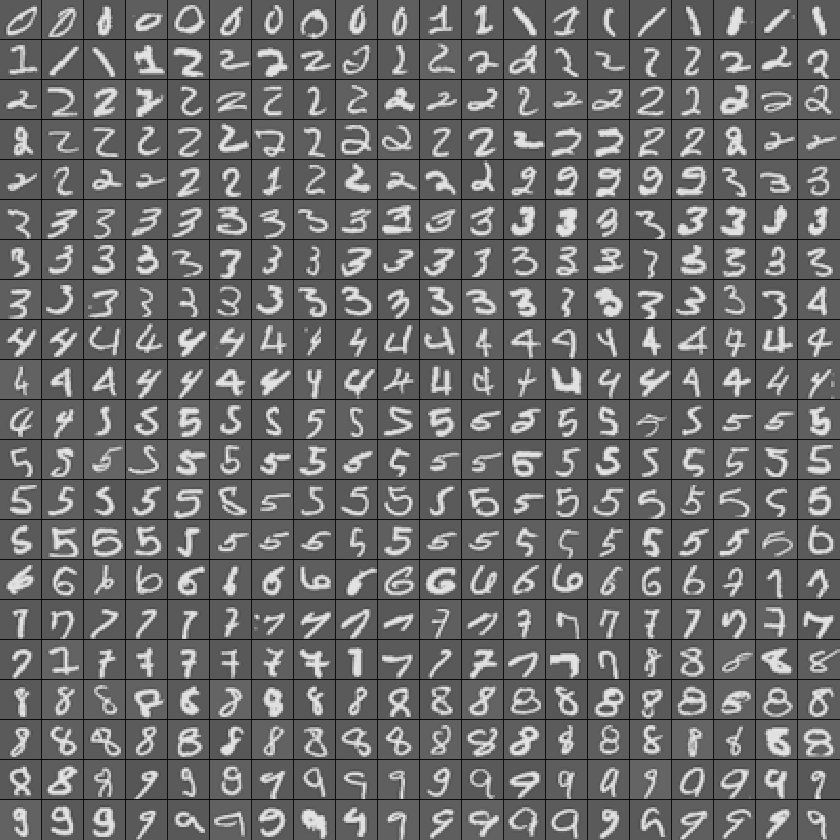

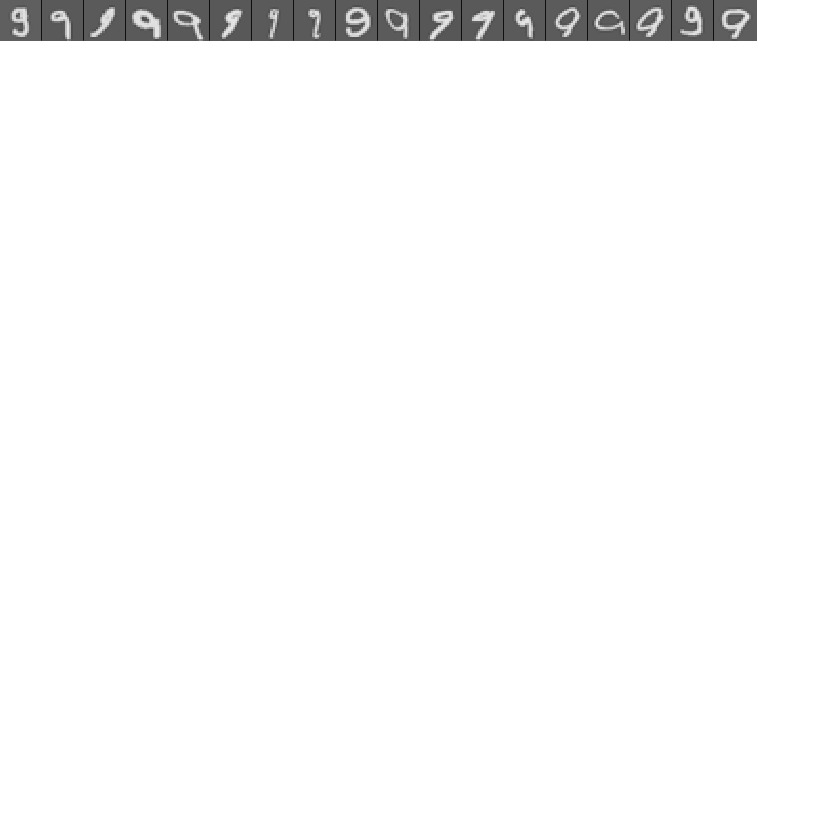

In [9]:
plot_digits(X[which(results$Correct == 0),])

It looks like there was a pretty even spread of misclassifications here

---

##  **Part 2:** Neural Networks

Recognizing the same handwritten digits with neural networks

### Model Representation

Note: Image taken from [scikit-learn documentation](http://scikit-learn.org/stable/modules/neural_networks_supervised.html)

<img src="http://scikit-learn.org/stable/_images/multilayerperceptron_network.png" style="width: 300px">

**Input layer $(X_n)$:** 400 nodes (excluding bias node)

**Hidden layer $(a_k$ or $s_l)$ :** 25 nodes (in one layer ($L=1$), excluding bias node)

**Output layer $(f(X))$:** 10 nodes (binary for each digit)

In feed-forward propagation, each node for each step (after the input layer) is calculated multiplying the previous nodes by their respective weights (provided in this exercise, but will be calculated with backpropagation in the next exercise), summing these products, and then performing an activation function - the sigmoid function in this case.  Here is a mathematical representation:

$a = f(\sum_{i=0}^N w_i x_i)$

- Notation:
    - **$w_i$:** Weight
    - **$x_i$:** Node
    - **$f()$:** Activation function

In [10]:
# Loading in the weights from the .mat files
data <- readMat('ex3/ex3weights.mat')

# Assigning theta1/2 and removing data from environment
theta1 <- data$Theta1
theta2 <- data$Theta2
rm(data)  # Clearing data from environment

In [11]:
sigmoid <- function(z) {
  # Calculates the sigmoid function for use as the activation function in the neural network
  z <- 1/(1+exp(-z))
  return(z)
}

neural_network_prediction <- function(X) {
  # Returns the digit prediction using the weights provided for the exercise
  # Assumes X already contains the bias term
  theta1 <- as.matrix(theta1)
  theta2 <- as.matrix(theta2)
  X <- as.matrix(X)
  
  hiddenLayer <- X %*% t(theta1) %>%  # Multiplying by the weights
                   sigmoid() %>%  # Activation function
                   cbind(1, .)  # Adding the bias term
  
  outputLayer <- hiddenLayer %*% t(theta2) %>%  # Multiplying by the weights
                   sigmoid() %>%  # Activation function
                   data.frame()
  colnames(outputLayer) <- c(1:9, 0)  # Adjusting the names due to R's 1-indexing
  
  # Grabbing the column name with the highest class probability
  prediction <- colnames(outputLayer)[max.col(outputLayer,ties.method="first")]
  
  return(prediction)
}

predictions <- neural_network_prediction(X)

Checking the accuracy

The exercise states that the training accuracy should be around 97.5%

In [12]:
results <- data.frame(Prediction = as.numeric(predictions)) %>% 
  mutate(Actual = y)

results$Correct <- ifelse(results$Prediction == results$Actual, 1, 0)

cat('Our accuracy:', mean(results$Correct))

Our accuracy: 0.9752

Perfect!